# Pima Indians Diabetes – Classificazione
**Pipeline:** dataset → preprocessing → training → valutazione (ROC/AUC, conf. matrix)
Fonte: UCI Machine Learning Repository.

In [1]:
# %pip install pandas scikit-learn matplotlib seaborn xgboost

In [2]:
import os, io, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, urllib.request as urlreq
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

SEED = 42
np.random.seed(SEED)

DATA_PATH = '../data/pima-indians-diabetes.csv'
UCI_URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
COLUMNS = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

if not os.path.exists(DATA_PATH):
    try:
        print('Downloading dataset from UCI mirror...')
        data_bytes = urlreq.urlopen(UCI_URL).read()
        open(DATA_PATH, 'wb').write(data_bytes)
    except Exception as e:
        print('Download failed:', e)

df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1) Preprocessing

In [3]:
# Alcuni campi non possono essere 0 fisiologicamente: sostituiamo 0 con NaN e imputiamo
cols_zero_impossible = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_zero_impossible] = df[cols_zero_impossible].replace(0, np.nan)
df[cols_zero_impossible] = df[cols_zero_impossible].fillna(df[cols_zero_impossible].median())

X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## 2) Training (Logistic Regression, XGBoost) con CV

In [4]:
logreg = LogisticRegression(max_iter=1000, random_state=SEED)
xgb = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, random_state=SEED, eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
auc_lr = cross_val_score(logreg, X_train_sc, y_train, cv=cv, scoring='roc_auc').mean()
auc_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='roc_auc').mean()
print(f'CV AUC – LogisticRegression: {auc_lr:.3f} | XGBoost: {auc_xgb:.3f}')

logreg.fit(X_train_sc, y_train)
xgb.fit(X_train, y_train)

CV AUC – LogisticRegression: 0.843 | XGBoost: 0.811


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 3) Valutazione su test (ROC/AUC, Confusion Matrix)

Test AUC – LR: 0.813 | XGB: 0.825


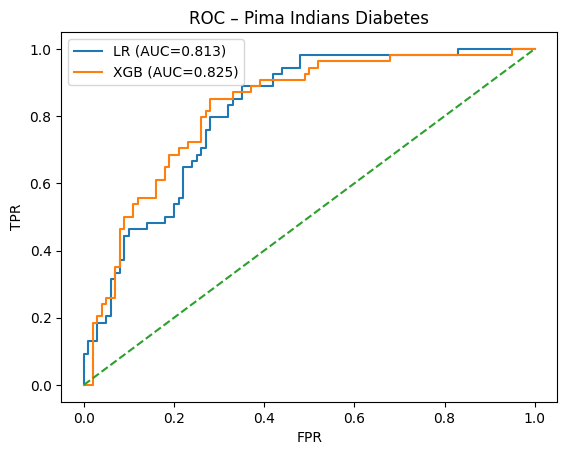

Confusion Matrix (LR @0.5):
 [[82 18]
 [27 27]]

Classification report (LR):
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



In [5]:
from sklearn.metrics import RocCurveDisplay
y_prob_lr = logreg.predict_proba(X_test_sc)[:,1]
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f'Test AUC – LR: {auc_lr:.3f} | XGB: {auc_xgb:.3f}')

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(); plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={auc_lr:.3f})'); plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={auc_xgb:.3f})')
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Pima Indians Diabetes'); plt.legend(); plt.show()

y_pred_lr = (y_prob_lr >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix (LR @0.5):\n', cm)
print('\nClassification report (LR):\n', classification_report(y_test, y_pred_lr))